### Introduction

This notebook is a demonstration of the robustness testing framework.

The framework is designed to test the robustness of a trading strategy across different scenarios and is designed to be flexible and can be used with any trading strategy.

The strategy used in this example is the RSI PowerZones strategy, which is a momentum strategy that uses the RSI to identify entry and exit points.

Let's get into it.

In [1]:
import pandas as pd
import yfinance as yf
import talib
import vectorbt as vbt
import numpy as np
import matplotlib.pyplot as plt
import empyrical as ep
from itertools import product
from tqdm import tqdm
tqdm.pandas()

In [2]:
import warnings
warnings.filterwarnings('ignore')


### Loading Data

We will use SPY for this example, and Yahoo Finance to load the historical adjusted close prices.


In [14]:
# Load data
data = yf.download('SPY')['Close']['SPY']
data.tail()

[*********************100%***********************]  1 of 1 completed


Date
2025-02-19    612.929993
2025-02-20    610.380005
2025-02-21    599.940002
2025-02-24    597.210022
2025-02-25    594.239990
Name: SPY, dtype: float64

### The Strategy

We use the RSI PowerZones strategy on the SPY to demonstrate the robustness testing framework.

More on the strategy in the book "Buy the fear, sell the greed" by Larry Connors (https://www.amazon.com/Buy-Fear-Sell-Greed-Behavioral/dp/0578206501)

##### First, define the strategy

We need to create a function that will take the data and the parameters of the strategy, and return the portfolio object:
- trades
- returns
- equity curve

In this case, we will use vectorbt to backtest the strategy. Any other framework can be used as well, just make sure to return the output in the same structure.


In [11]:
def strategy(data, sma_window, rsi_window, rsi_lower1, rsi_lower2, rsi_upper):

    # Computing indicators
    sma200 = data.rolling(sma_window).mean().shift(1)
    if len(data.shape) > 1:
        rsi4 = {} 
        for c in data.columns:
            rsi4[c] = talib.RSI(data[c], rsi_window)
        rsi4 = pd.DataFrame(rsi4)
    else:
        rsi4 = talib.RSI(data, rsi_window)
        
    # Generating signals
    entries = (data > sma200) & (rsi4.vbt.crossed_below(rsi_lower1) | rsi4.vbt.crossed_below(rsi_lower2))
    exits = rsi4.vbt.crossed_above(rsi_upper)
    
    # Run backtest
    pf = vbt.Portfolio.from_signals(data, entries, exits, size=100, size_type='value', fees=0.001)

    return pf

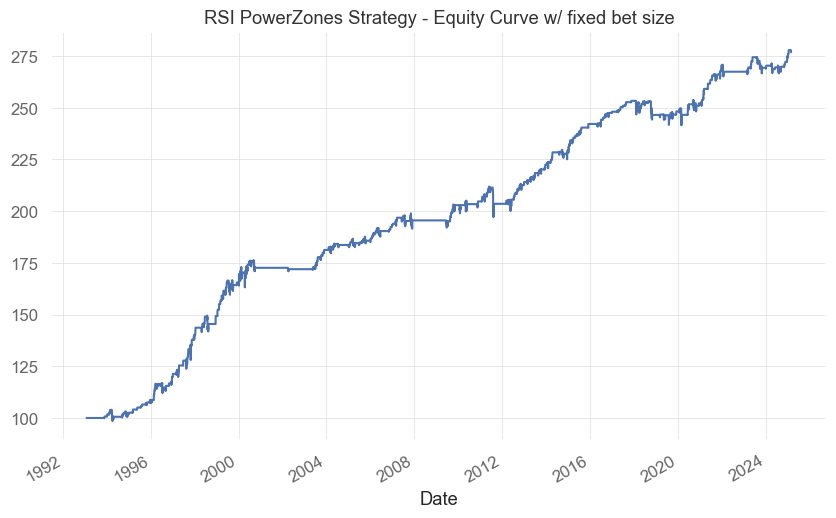

In [15]:
# Backtest selected parameters (derived from the book)
pf = strategy(data, 200, 4, 30, 25, 55)
pf.value().plot()
plt.title('RSI PowerZones Strategy - Equity Curve w/ fixed bet size')
plt.show()


In [40]:
# Printing the trade history
pf.trades.records_readable.tail()

,Exit Trade Id,Column,Size,Entry Timestamp,Avg Entry Price,Entry Fees,Exit Timestamp,Avg Exit Price,Exit Fees,PnL,Return,Direction,Status,Position Id
253,253,0,0.171296,2024-11-15,583.785156,0.1,2024-11-21,591.678589,0.101352,1.150760,0.011508,Long,Closed,253
254,254,0,0.171141,2024-12-18,584.313416,0.1,2024-12-24,601.299988,0.102907,2.704192,0.027042,Long,Closed,254
255,255,0,0.170004,2024-12-30,588.219971,0.1,2025-01-06,595.359985,0.101214,1.012620,0.010126,Long,Closed,255
256,256,0,0.172268,2025-01-10,580.489990,0.1,2025-01-15,592.780029,0.102117,1.915066,0.019151,Long,Closed,256
257,257,0,0.166683,2025-02-21,599.940002,0.1,2025-02-25,594.239990,0.000000,-1.050097,-0.010501,Long,Open,257


## Robustness Testing

### Test 1: Different Timeframes


This test is used to evaluate the strategy's performance across different timeframes. The idea is that if the strategy is robust, it should perform well across different timeframes, with slight variations in performance.

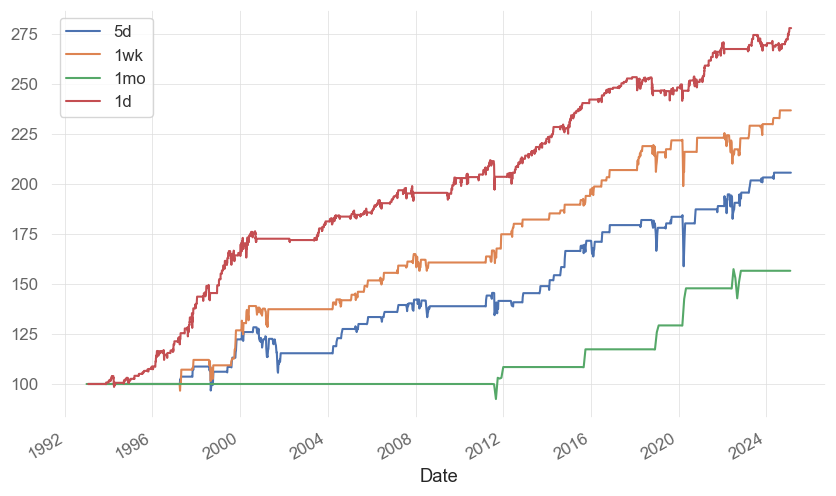

In [44]:
for tf in ['5d', '1wk', '1mo', '1d']:
    data = yf.download('SPY', interval=tf, progress=False)['Adj Close']
    pf = strategy(data, 200, 4, 30, 25, 55)
    pf.value().plot(label=tf)
plt.legend()
plt.show()

Indeed, the strategy shows strong performance across most timeframes **higher granularity** timeframes, yet the performance is best on the 1d timeframe (as anticipated). The strategy continues to be profitable across various timeframes, although returns decrease as the granularity increases. This is expected since higher timeframes typically involve fewer trades.

Let's see if this holds true for lower granularity.


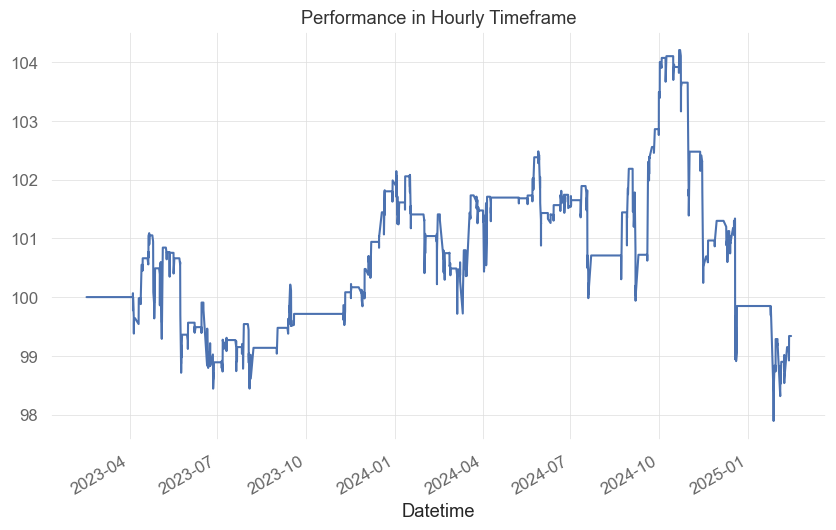

In [46]:
for tf in ['1h']:
    data = yf.download('SPY', interval=tf, progress=False, period='2y')['Adj Close']
    pf = strategy(data, 200, 4, 30, 25, 55)
    pf.value().plot(label=tf)
plt.title('Performance in Hourly Timeframe')
plt.show()

# Resetting the data to the original timeframe
data = yf.download('SPY', interval='1d', progress=False)['Adj Close']


The performance deteriorates at lower granularity. This also makes sense, as the higher trading frequency means more trades, and thus more fees.


### Test 2: Different (related) Markets


This test is used to evaluate the strategy's performance across different markets. 

The idea is that if the strategy is robust, it should perform well across different markets, with slight variations in performance.

We will use ETFs that have a high correlation with the SPY to test the strategy

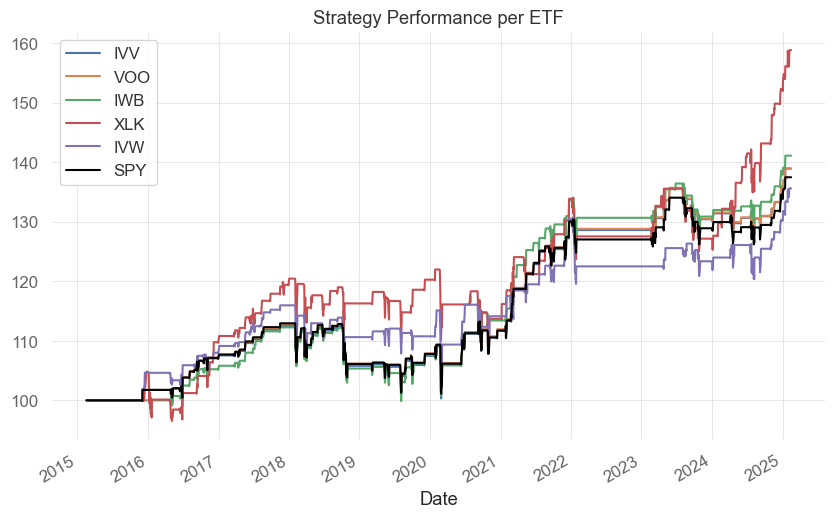

In [51]:
for market in ['IVV', 'VOO', 'IWB', 'XLK', 'IVW']:
    data = yf.download(market, progress=False, period='10y')['Adj Close']
    pf = strategy(data, 200, 4, 30, 25, 55)
    pf.value().plot(label=market)

data = yf.download('spy', progress=False, period='10y')['Adj Close']
pf = strategy(data, 200, 4, 30, 25, 55)
pf.value().plot(label='SPY', color='black')
plt.title('Strategy Performance per ETF')
plt.legend()
plt.show()

# Resetting the data to the original timeframe
data = yf.download('spy', progress=False)['Adj Close']

The strategy shows strong performance across most ETFs that have a high correlation with the SPY, indicating robustness, while for some it yields even better results.





### Test 3: Monte Carlo Trade Reshuffling

This Monte Carlo simulation test is used to evaluate the strategy, if the trades path is random. 

The idea is that if the strategy is robust, regardless of the trades path, the strategy should perform within expectations.

** Be careful to use a **fixed bet size** for running this test, as different bet sizing will interfere with the results. All trades are consider equal.


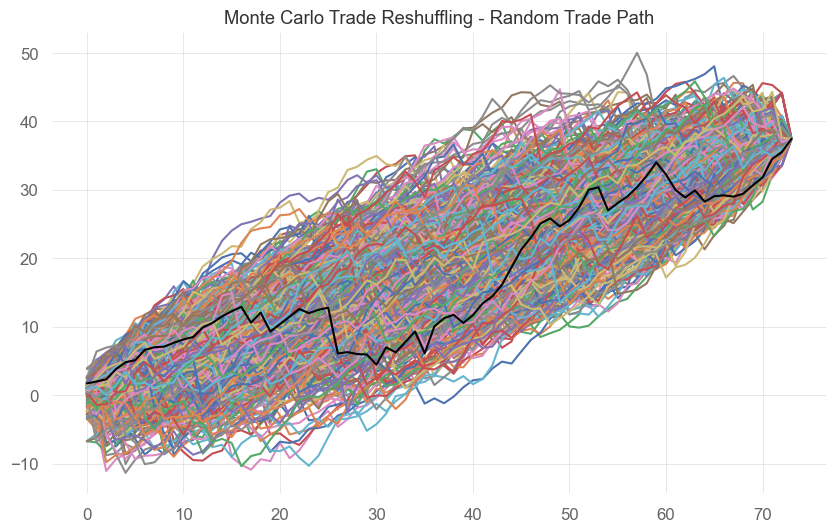

In [59]:
trades=pf.trades.records_readable

n_simulations = 500
equity_curves = []

for i in range(n_simulations):
    shuffled_trades = np.random.permutation(trades.PnL.to_numpy()) 
    equity_curve = pd.Series(shuffled_trades).cumsum()
    equity_curves.append(equity_curve)

pd.DataFrame(equity_curves).T.plot()
trades.PnL.cumsum().plot(color='black')
plt.legend().set_visible(False)
plt.title('Monte Carlo Trade Reshuffling - Random Trade Path')
plt.show()

The proximity of the equity curves along with the fact that all are profitable in the end signals robustness.




### Test 4: Noise Testing


In this test, we formulate 500 simulated prices using Geometric Brownian Motion and run the strategy on them. 

The idea is that, given GBM prices are essentially a random walk with a drift, a strategy that has true edge should **not** produce consistent results on this simulation. 

Let's take a look.

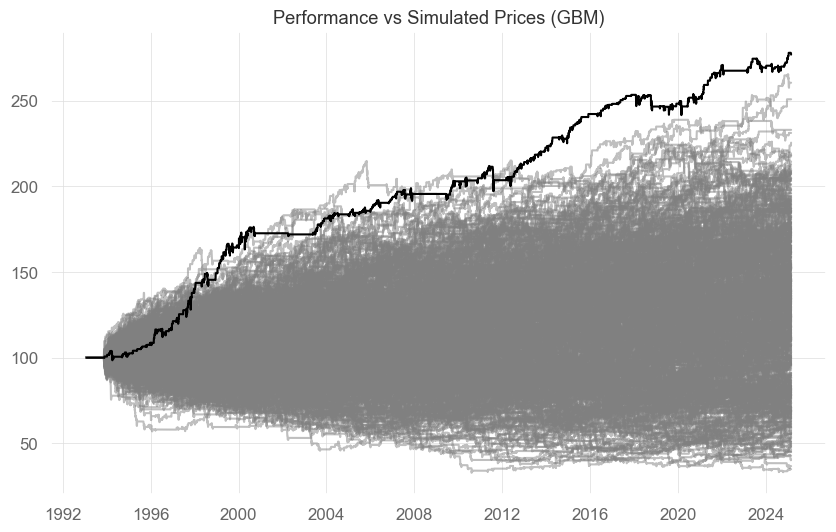

In [31]:
# This robustness test is all about testing the strategy on GBM generated prices

def gbm(initial_price, returns, num_samples):
    resampled_returns = np.random.choice(returns, size=num_samples, replace=True)
    prices = [initial_price]
    for ret in resampled_returns:
        prices.append(prices[-1] * (1 + ret))
    return prices

# Get initial price and returns
initial_price = data.iloc[0]
returns = data.pct_change().dropna().values.tolist()

# Generate 100 random price paths using geometric brownian motion
n_samples = len(data) - 1  # Subtract 1 since gbm() adds an extra price
bootstrap_prices = [gbm(initial_price, returns, n_samples) for _ in range(500)]
bootstrap_prices = pd.DataFrame(bootstrap_prices).T 
bootstrap_prices.index = data.index

# Run backtest in each simulated price
_pf = strategy(bootstrap_prices, 200, 4, 30, 25, 55)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(_pf.value(), color='grey', alpha=0.5, label='GBM Prices')
plt.plot(pf.value(), color='black', label='Actual Prices')
plt.legend().set_visible(False)
plt.title('Performance vs Simulated Prices (GBM)')
plt.show()


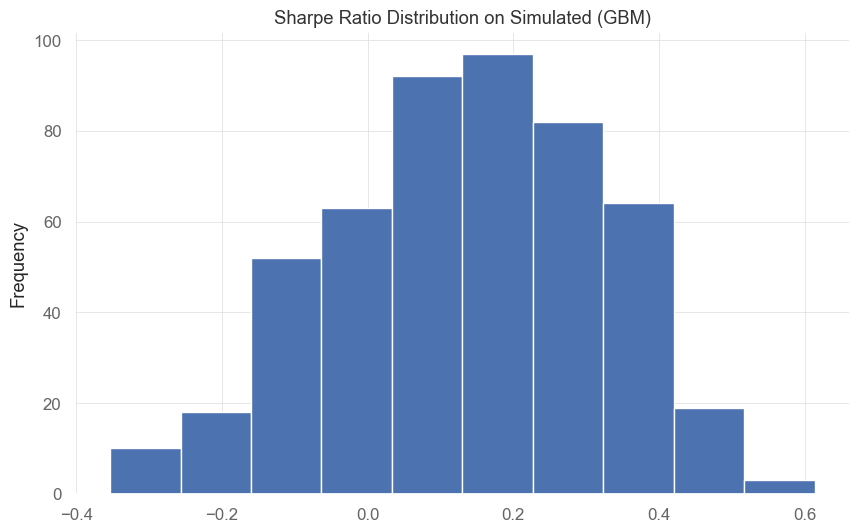

In [36]:
_pf.returns().apply(ep.sharpe_ratio).plot(kind='hist')
plt.title('Sharpe Ratio Distribution on Simulated (GBM)')
plt.show()

Since GBM-generated prices follow a random walk with drift, any strategy applied to them should produce random performance outcomes. This expectation is confirmed by our results, where:

(a) The equity curve exhibits a **random trajectory**, consistent with the lack of exploitable patterns in the data.

(b) The **distribution** of Sharpe Ratios **is approximately normal**, centered around zero, indicating that performance is driven by chance rather than skill.

Because the strategy fails to generate consistent profits on random data, it suggests that its positive performance on real market data is likely due to genuine edge, rather than overfitting to noise.

### Test 5: Parameter Permutation Testing


100%|██████████| 450/450 [00:10<00:00, 42.63it/s]


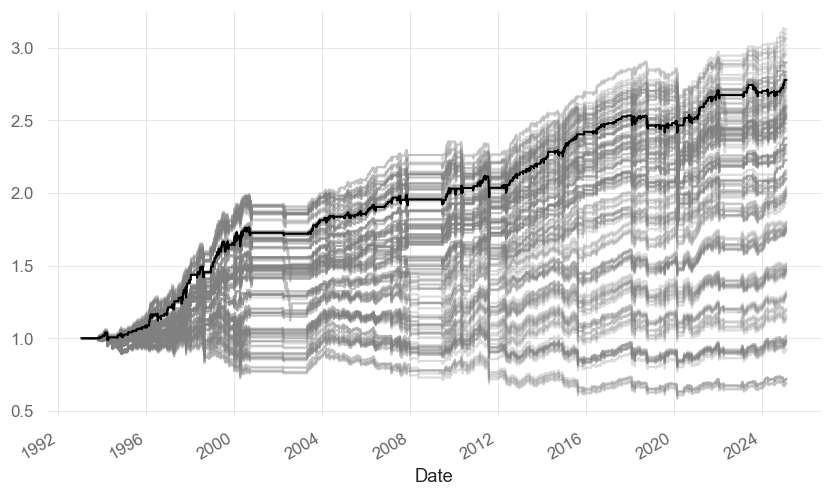

In [66]:
# Specify original parameters

params = [200, 4, 30, 25, 55]

# Specify parameter test ranges

param_ranges = [range(180, 230, 10), 
                range(2, 8, 2), 
                range(30, 40, 5), 
                range(20, 35, 5),
                range(45, 70, 5)]

# Run backtest on each permutation

v1, v2, v3, v4, v5 = param_ranges # replace with "perms_ranges" if automatic
perms_rets = {} 
for i, (x1, x2, x3, x4, x5) in tqdm(enumerate(list(product(v1, v2, v3, v4, v5))), total=len(list(product(v1, v2, v3, v4, v5)))):
    perms_rets[f'perm_{i}'] = strategy(data, x1, x2, x3, x4, x5).returns()


# Plotting

pd.DataFrame(perms_rets).add(1).cumprod().plot(color='grey', alpha=0.1)
strategy(data, 200, 4, 30, 25, 55).returns().add(1).cumprod().plot(color='black')
plt.legend().set_visible(False)
plt.show()

The strategy seems to perform well with slight changes in its parameters, yet there are multiple permutations with an apparently terrible performance. We might have overtested this, as we've run 450 permutations. It seems though that (a) the equity path is similar across all, and (b) the majority of the permutations tested are similar to the original (black). Yet, I conclude that the selected parameters are robust.


### Test 6: Variance Test


100%|██████████| 1000/1000 [00:01<00:00, 909.70it/s]


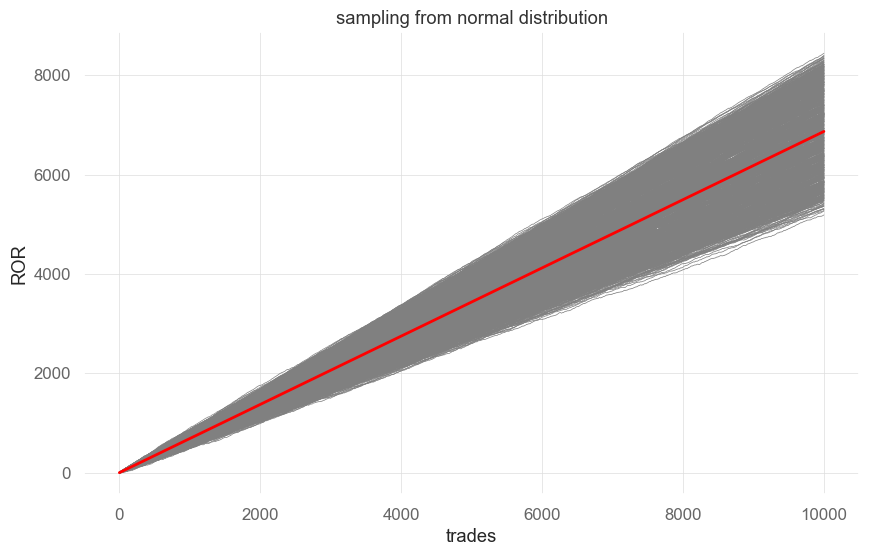

In [38]:
"""
Creates hypothetical equities of varying win rate (5% deviation from the original)

This test is critical, as it essentially summarizes what can happen if you allow 
the law of large numbers to play out, as it enables us to estimate where the equity may be after N trades.
    
More details here:
 - https://www.buildalpha.com/buildalpha-features/
 - https://www.linkedin.com/pulse/variance-testing-easy-way-detect-data-mining-bias-ali-h-askar-cqf/

"""

backtest_results = pf.trades.records_readable.PnL
n_simulations = 1000
n_trades = 10000 # specify according to the strategy's trading frequency (the higher the frequency, the higher the n_trades should be)
win_rate_variance = 0.05

# Calculate original win rate
original_win_rate = (backtest_results > 0).mean()

# Calculate win/loss average
pos = backtest_results[backtest_results>0].mean()
neg = backtest_results[backtest_results<0].mean()

# Initialize DataFrame to store results
results = pd.DataFrame(index=range(n_simulations), columns=['profit', 'drawdown'])
equity_curves_df = pd.DataFrame()
dd_df = {}


for i in tqdm(range(n_simulations)):
    # Adjust win rate within variance limits and make sure it's within [0, 1] range
    adjusted_win_rate = np.clip(original_win_rate + (np.random.rand() - 0.5) * 2 * win_rate_variance, 0, 1)

    # Sample trades with adjusted win rate
    _trades = np.random.choice([pos, neg], size=n_trades, p=[adjusted_win_rate, 1-adjusted_win_rate])
    
    # Calculate profit and equity curve
    profit = _trades.sum()
    equity_curve = np.cumsum(_trades)
    
    # Calculate maximum drawdown
    cummax = np.maximum.accumulate(equity_curve)
    drawdown = np.max(cummax - equity_curve)    

    equity_curves_df[i] = pd.Series(equity_curve)
    dd_df[i] = drawdown

# Plotting spaghetti chart
for i in range(n_simulations):
    plt.plot(equity_curves_df[i], color='gray', linewidth=0.5)

# Plotting mean equity curve
plt.plot(equity_curves_df.mean(axis=1), color='red', linewidth=2)
# plt.plot(rets.cumsum().values, color='green')
plt.title('sampling from normal distribution')
plt.xlabel('trades')
plt.ylabel('ROR')
plt.show()

This test shows that the strategy remains profitable in the long run, even with varying win rate, as demonstrated by the closely aligned equity values. It's a pass here as well.



